This practical work, on motion estimation, has 3 different parts, corresponding to three families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow
- Parametric motion estimation.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from me_ssd import me_ssd
from displayMVF import displayMVF
from fracMc import fracMc
from PSNR import PSNR
from me_sad import me_sad
from HornSchunck import HS
from applyAffineMotion import applyAffineMotion
from angle2D import angle2D
from gradient import gradient
from medianFilter import medianFilter

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [2]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20acade7730>)

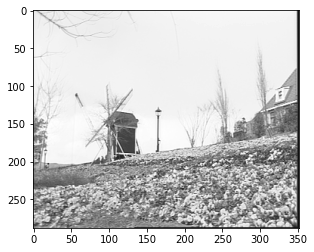

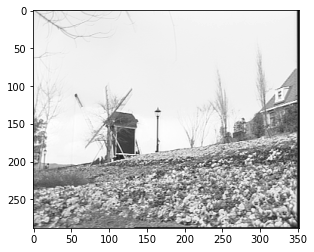

In [3]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [4]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Code the me_ssd function in the me_ssd file. First, implement the unregularized function.

In [5]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Write your remarks. Are there errors? If yes, where and why?

Nous pouvons voir dans l'image ci-dessous que les vecteurs de mouvement de certains blocs, notamment dans la région du ciel, les éloignent de leurs positions initiales. Cette erreur est due au fait que l'on ignore la distance entre les 2 blocs, et que l'on ne prend en compte que la différence des intensités, dans ce cas on peut avoir 2 blocs dans une région homogène ayant une dissimilarité très proche.

Change the block size and the search area radius. How does it impact your results?

En augmentant la taille du bloc, on diminue la probabilité de trouver un bloc éloigné qui a moins de dissimilarité que les blocs voisins, c'est pourquoi le nombre d'erreurs dans les vecteurs de mouvement diminue. D'autre part, l'augmentation du rayon de la zone augmente la probabilité de trouver plus de blocs ayant moins de dissimilarité, donc le nombre d'erreurs augmente.

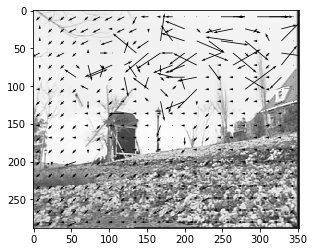

In [6]:
displayMVF(im1,mvf_ssd,brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image. Display the motion compensated image. What can you observe ?

Ici, on déplace un bloc grâce aux vecteurs de mouvement. Si la nouvelle image est plus proche d'im2, le résultat sera considéré comme meilleur. En appliquant la compensation de mouvement à l'image im1, on se rapproche d'im2.

TO DO : code the motion compensation function

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20acbf18b50>)

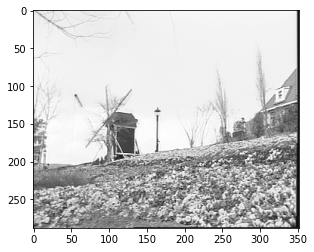

In [7]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

What is the definition of PSNR ? Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

Le PSNR est une mesure de la différence entre une image originale et une image modifiée, en termes de bruit introduit par la modification. Le PSNR se calcule comme le rapport entre la puissance maximale du signal (signal maximal possible) et la puissance du bruit (différence entre les images). Plus le PSNR est élevé, meilleure est la qualité de l'image, car cela signifie que le bruit est faible par rapport au signal d'origine. 

$$\mathrm{PSNR} = 10 \log_{10} \left(\frac{d^2}{\mathrm{EQM}}\right)$$

Le PSNR entre mc_ssd et im2 est plus faible qu'entre im1 et im2, car les mouvements estimés permettent d'avoir une image plus proche de im2.

Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

In [8]:
psnr_im1 = PSNR(im2,im1)
print('PSNR im2 im1 :',psnr_im1)
psnr_ssd = PSNR(im2,mc_ssd)
print('PSNR im2 mc_ssd :',psnr_ssd)

PSNR im2 im1 : 18.786509322935075
PSNR im2 mc_ssd : 22.706093367942778


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [9]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

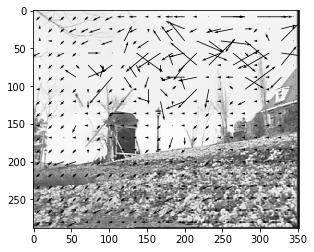

In [10]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

Le SSD est un petit peu moins régulier. Nos résultats de PSNR sont très proche. Le résultat est légérement meilleur pour le SSD, ce qui est normal puisque le SSD est optimisé pour maximiser le PSNR. En augmentant la taille des blocs (passage de 16 à 32), les PSNR des deux méthodes se rapprochent (22.45 pour la SSD, 22.44 pour la SAD).

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20acc01ddf0>)

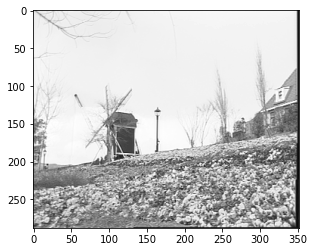

In [11]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [12]:
psnr_sad = PSNR(im2,mc_sad)
print('PSNR im2 mc_sad :',psnr_sad)

PSNR im2 mc_sad : 22.624558403978142


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

On voit que le PSNR décroit avec le terme de régularisation. Cela s'explique car, par définition, SSD correspond à maximiser le PSNR. Ainsi, à mesure que le terme de régularisation augmente, on maximise de moins en moins le PSNR.

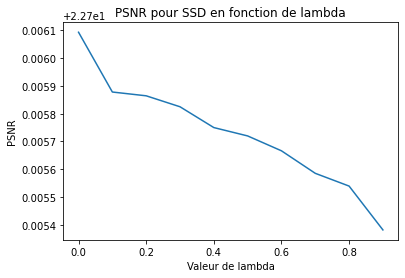

In [14]:
psnr_ssd_reg = []
lamb_values = []

for i in range(10):
    lamb = 0.1*i
    mvf_ssd_reg, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb)
    mc_ssd_reg = fracMc(im1, mvf_ssd_reg)
    psnr = PSNR(im2, mc_ssd_reg)
    psnr_ssd_reg.append(psnr)
    lamb_values.append(lamb)

plt.plot(lamb_values, psnr_ssd_reg)
plt.xlabel('Valeur de lambda')
plt.ylabel('PSNR')
plt.title('PSNR pour SSD en fonction de lambda')
plt.show()

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

On voit que le PSNR décroit aussi avec le terme de régularisation, et la décroissance est plus forte qu'avec le SSD.

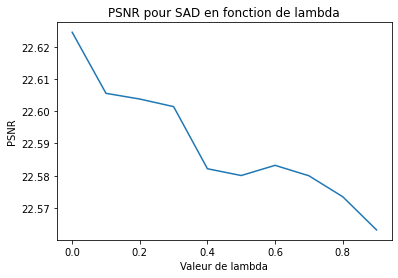

In [15]:
psnr_sad_reg = []
lamb_values = []

for i in range(10):
    lamb = 0.1*i
    mvf_sad_reg, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb)
    mc_sad_reg = fracMc(im1, mvf_sad_reg)
    psnr = PSNR(im2, mc_sad_reg)
    psnr_sad_reg.append(psnr)
    lamb_values.append(lamb)

plt.plot(lamb_values, psnr_sad_reg)
plt.xlabel('Valeur de lambda')
plt.ylabel('PSNR')
plt.title('PSNR pour SAD en fonction de lambda')
plt.show()

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [10]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2373d769f10>)

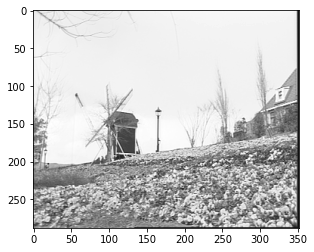

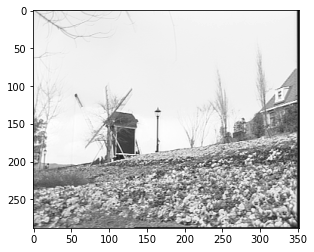

In [11]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithms to initialize you algorithm.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [12]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

alpha = 100
ite = 100

uInitial = np.zeros(im2.shape) # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = np.zeros(im2.shape)
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

Contrairement aux algorithmes de block matching, la méthode de Horn and Schunck estime la vitesse de chaque pixel de l'image. Il semble moins sensible aux mouvements rapides ou brusques, et plus robustes aux changements de luminosité et de contraste entre les images successives. la méthode est plus longue à s'éxecuter, mais semble aussi plus précise.

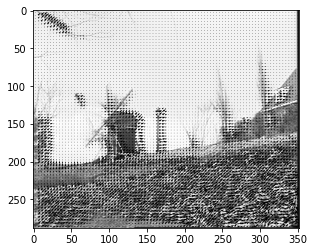

In [13]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [14]:
psnr_hs

18.407801069282055

## End of TP 1

# III - Parametric estimation
In this last part, we will work on parametric estimation, both using direct and indirect methods.
## III-1- Direct parametric estimation
### III-1-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

LA transformée de Fourier discrete (DTFT) en 2D pour un signal $a(n,m)$ est :

$$A(\omega_1,\omega_2) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n,m) e^{-j(\omega_1 n + \omega_2 m)}$$

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

$$B(\omega_1,\omega_2) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n,m) e^{-j(\omega_1 n + \omega_2 m)} = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c, m+d) e^{-j(\omega_1 n + \omega_2 m)} = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-j(\omega_1 (n'-c) + \omega_2 (m'-d))} $$
$$= e^{-j(\omega_1 c + \omega_2 d)} \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-j(\omega_1 n' + \omega_2 m')} = e^{-j(\omega_1 c + \omega_2 d)} A(\omega_1,\omega_2)$$

Cette équation montre que la DTFT de $b(n,m)$ est obtenue en multipliant la DTFT de $a(n,m)$ avec un vecteur phase $e^{-j(\omega_1 c + \omega_2 d)}$ qui dépend de $(c,d)$.


Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

Avec la réponse précédente, on a l'expression dérivée suivante :

$$\hat{b}(\nu_x,\nu_y) = e^{-i2\pi (c\nu_x + d \nu_y)} \hat{a}(\nu_x,\nu_y) \Leftrightarrow \frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = e^{-i2\pi (c\nu_x + d \nu_y)}$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DF.

$$ A(k_1,k_2) = \frac{1}{N^2} \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) e^{-j 2\pi \left(\frac{k_1 n}{N} + \frac{k_2 m}{N}\right)} $$

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N^2}\right)
$$

On procède de la même manière que pour DTFT, donc tout d'abord :

$$ B(k_1,k_2) = e^{-j2\pi\left(\frac{ck_1}{N} + \frac{dk_2}{N}\right)} A(k_1,k_2) \Leftrightarrow \frac{A(k_1,k_2)}{B(k_1,k_2)} = \frac{1}{e^{-j2\pi\left(\frac{ck_1}{N} + \frac{dk_2}{N}\right)}} 
= e^{j2\pi\left(\frac{ck_1}{N} + \frac{dk_2}{N}\right)}$$

Maintenant que le terme linéaire de phase est apparu, regardons quelles sont les conditions pour le mettre en facteur :

$$\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \frac{1}{N^2} \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \frac{a(n,m)}{b(n,m)} e^{-j2\pi\left(\frac{kn}{N} + \frac{lm}{N}\right)} = \frac{1}{N^2} \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \frac{a(n+c,m+d)}{a(n,m)} e^{-j2\pi\left(\frac{kn}{N} + \frac{lm}{N}\right)} $$
$$= \frac{1}{N^2} \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \frac{a(n+c,m+d)}{a(n,m)} e^{-j2\pi\left(\frac{k(n+c)}{N} + \frac{l(m+d)}{N}\right)} e^{j2\pi\left(\frac{kc}{N} + \frac{ld}{N}\right)}$$

Si $\frac{a(n+c,m+d)}{a(n,m)}$ depend uniquement de $(c,d)$ et pas de $(n,m)$, alors on peut mettre le terme linéaire de phase  $e^{j2\pi\left(\frac{kc}{N} + \frac{ld}{N}\right)}$ en facteur :

$$\frac{a(n+c,m+d)}{a(n,m)} e^{-j2\pi\left(\frac{kn}{N} + \frac{lm}{N}\right)} e^{j2\pi\left(\frac{kn}{N} + \frac{lm}{N}\right)} = \frac{a(n+c,m+d)}{a(n,m)}$$

Ainsi, le ration des DFT de $a(n,m)$ and $b(n,m)$ a un terme de phase linéaire si et seulement si $\frac{a(n+c,m+d)}{a(n,m)}$ dépend seulement de $(c,d)$ et pas de $(n,m)$, donc $a(n,m)$ et $b(n,m)$ doivent différer uniquement par $e^{j2\pi\left(\frac{cn}{N} + \frac{dm}{N}\right)}$. 

### III-1-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding of not some noise into the image.

In [87]:
#im1 = loadmat('ball.mat')['im1']
#im1 = im1.astype('float')

im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x23a0c3ed4c0>)

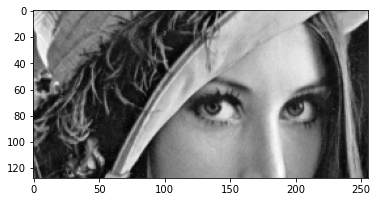

In [88]:
# Potentially add noise to the image
sigma = 0
im1 = im1 + sigma*np.random.randn(np.shape(im1)[0],np.shape(im1)[1])
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x23a0ca7f2e0>)

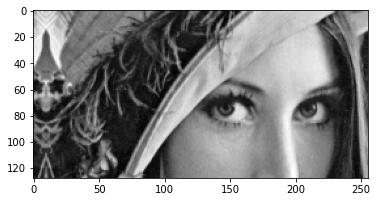

In [100]:
horiz_displacement = 10.0
vert_displacement  = 1.0
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

In [101]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

In [102]:
phi = angle2D(IM1/IM2)

Display phi. Is it a linear plane and why?

Lorsqu'il n'y a pas de bruit ajouté, la translation de l'image peut être représentée comme une phase linéaire constante dans la FFT : la phase relative entre les deux FFT IM1 et IM2 sera une phase linéaire constante, donc la fonction angle2D(IM1/IM2) donnera une carte de phase constante qui sera linéaire.

Cependant, lorsque l'on ajoute du bruit, cela introduit des variations aléatoires dans la phase des FFT, ce qui rend la phase relative entre les deux images non linéaire. Ainsi, la carte de phase obtenue à partir de la fonction angle2D(IM1/IM2) peut être plus complexe qu'une simple phase linéaire et ne peut donc pas être représentée par un plan.


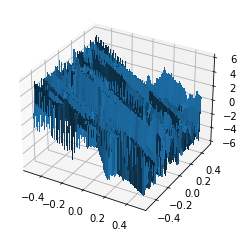

In [103]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [104]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [105]:
print(GX)
print(GY)

-9.00106889405032
0.17547926329211805


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

Le code ci-dessus effectue une approximation par moindres carrés de la fonction phi et permet d'estimer les paramètres de la translation. Pour cela, il soustrait la valeur de phi en son centre à la matrice phi, puis applique un filtre médian à cette matrice pour obtenir une matrice t. Ensuite, il crée une matrice A qui contient les dérivées partielles de phi par rapport aux colonnes et aux lignes, puis il crée un vecteur b contenant les valeurs de t. Enfin, il calcule les valeurs estimées de la translation en résolvant l'équation Ax = b à l'aide de la pseudo-inverse de A et en multipliant le résultat par le vecteur b.

In [106]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)

In [107]:
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [108]:
print(bEst)

[-7.56783721  0.14970607]


Relaunch the above code:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

Déplacement appliqué : [-10.  -1.]

- Balle sans bruit : [-10.  -1.], l'estilation de la translation est parfaite  
- Balle avec bruit (sigma = 1) : [-9.74633628 -1.01287558], l'estimation de la translation est bonne  
- Léna sans bruit : [-7.56783721  0.14970607], l'estimation de la translation est moins précise mais on distingue quand même la différence d'échelle entre le mouvement horizontal et vertical  
- Léna avec bruit (sigma = 1) : [-7.43910839  0.3641246 ], l'estimation de la translation est semblable à celle sans bruit, elle est peu précise mais on distingue quand même la différence d'échelle entre le mouvement horizontal et vertical

Le calcul de translation fonctionne bien sur la balle car l'image est relativement uniforme et le contour est clairement défini, ce qui facilite la détection du gradient. Par conséquent, la méthode de calcul de translation fonctionne bien et fournit une estimation précise des paramètres de translation.

En revanche, sur une image complexe comme le portrait de Léna, la détection de gradient est plus difficile. De plus, l'image peut contenir plusieurs contours, ce qui peut causer des erreurs dans le calcul de translation.

L'influence du bruit est aussi importante, car le bruit peut introduire des perturbations dans le calcul du gradient, ce qui peut entraîner des erreurs dans l'estimation des paramètres de translation. Les filtres de lissage, comme le filtre médian, peuvent aider à réduire le bruit et à améliorer la qualité de l'image avant de calculer la translation.

# III-2-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

résultats : 

- Léna sans bruit par block-matching : [10.0, 1.0]
- Léna sans bruit par optical flow : [4.594046514810897, 0.3708511734101335]
- Léna avec bruit par block-matching : [10.0, 1.0]
- Léna avec bruit par optical flow : [4.589231257686571, 0.36857741177419323]

Finally, compare all the parametric estimation methods when the translation values are not integer.

On a pris :
horiz_displacement = 5.3
vert_displacement  = 1.2

- Léna sans bruit par block-matching : [5.0, 1.0]
- Léna sans bruit par optical flow : [1.9951361290884257, 0.5211944889960876]
- Léna avec bruit par block-matching : [5.0, 1.0]
- Léna avec bruit par optical flow : [1.9944065159638091, 0.5173119955148984]

On voit que par block-matching, le calcul se limite à un entier, alors que la variation est relevé par optical flow. 
Je pense que mon calcul par optical flow présrnte une erreur au vu des valeurs qui semblent toujours éloignées des translations. Cependant, on note la corrélation entre la variation de translation non entière et la variation de translation estimée par optical flow.

10.0
1.0


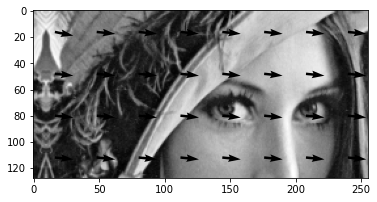

In [109]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

1.9951361290884257
0.5211944889960876


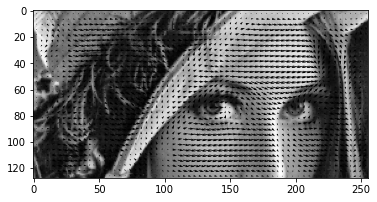

In [99]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)